## Libraries

In [3]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 188.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Libraries
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lightgbm import LGBMRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, hour, dayofweek, month, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

Matplotlib created a temporary cache directory at /scratch/zmosley/job_39710529/matplotlib-vaym10bo because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
spark = SparkSession.builder \
    .appName("NYC Taxi Full Dataset") \
    .config("spark.executor.instances", "20") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "10g") \
    .config("spark.driver.memory", "40g") \
    .config("spark.driver.cores", "4") \
    .config("spark.sql.shuffle.partitions", "300") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .getOrCreate()


## Import Data

In [4]:
# IMPORT 5 YEARS

base_path = "/expanse/lustre/projects/uci150/rvasappanavara/shared/nyc_taxi_data/"
file_paths = sorted(glob(f"{base_path}/yellow_tripdata_202[0-4]-*.parquet"))

# Fixes schema compatibility errors
dfs = []
for path in file_paths:
    df = spark.read.parquet(f"file://{path}")
    df = df.withColumn("airport_fee", col("airport_fee").cast("double"))
    dfs.append(df)

raw_df = dfs[0]
for other_df in dfs[1:]:
    raw_df = raw_df.unionByName(other_df)

In [4]:
# Shape of df
num_rows = raw_df.count()
num_cols = len(raw_df.columns)
print(f"Rows: {num_rows}, Columns: {num_cols}")

Rows: 174689444, Columns: 19


In [5]:
raw_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [6]:
raw_df.summary().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|           mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        airport_fee|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+---------------------+------------------+-------------------

# **EDA & Preprocessing**

In [5]:
df = raw_df

### fare_amount

In [6]:
# Examining possible outlier fares

print("Zero or negative fares:", df.filter(col("fare_amount") <= 0).count())
print("Fares < $3:", df.filter(col("fare_amount") < 3).count())
print("Fares > $100:", df.filter(col("fare_amount") > 100).count())
print("Fares > $200:", df.filter(col("fare_amount") > 200).count())

Zero or negative fares: 1669498
Fares < $3: 2216730
Fares > $100: 363769
Fares > $200: 43340


#### Standard City Rate, \$3 initial charge
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245
#### Removing fares under 3 dollars because that is the minimum charge and removing outlier fares above 200 dollars.

In [7]:
# Removing outliers, keeping fares between $3-$200
df = df.filter((col("fare_amount") >= 3) & (col("fare_amount") <= 200))

### Scatterplot of fare distribution

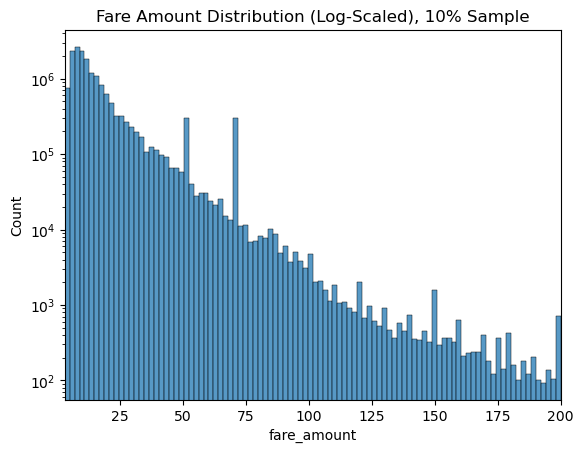

In [10]:
# Using 10% sample of data
scatterplot_sample = df.select("fare_amount").sample(fraction=0.1, seed=2).toPandas()

sns.histplot(scatterplot_sample["fare_amount"], bins=100)
plt.xlim(3, 200)  
plt.yscale("log")  # Log scale  to show more 
plt.title("Fare Amount Distribution (Log-Scaled), 10% Sample")
plt.show()

#### Most of the spikes are around round numbers, with the biggest spike at $70. 

#### After some research, its very common to charge flat rates on standard trips like to the airport. Specifically to JFK is $70.

#### John F. Kennedy Airport (JFK), To or from Manhattan (Rate Code 2), \$70 "Flat Fare."
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

### Extracting time based columns

In [8]:
# Trip time in minutes
df = df.withColumn("trip_time_minutes", (unix_timestamp("tpep_dropoff_datetime") - 
                                         unix_timestamp("tpep_pickup_datetime")) / 60)
# Fare per minute
df = df.withColumn("fare_per_min", col("fare_amount") / col("trip_time_minutes"))
# Fare per mile
df = df.withColumn("fare_per_mile", col("fare_amount") / col("trip_distance"))

In [9]:
df = df.withColumn("hour", hour(col("tpep_pickup_datetime"))) \
       .withColumn("dayofweek", dayofweek(col("tpep_pickup_datetime")) - 2) \
       .withColumn("month", month(col("tpep_pickup_datetime")))

### Passenger Count

#### Maximum Number of Passengers - The maximum number of passengers allowed in a yellow taxicab by law is 4 in a 4-passenger taxicab or 5 in a 5-passenger taxicab.
##### https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [10]:
# Filter for 1-5 passengers. 4 or 5 is max allowed by taxi law in NYC
df = df.withColumn("passenger_count", when(col("passenger_count") < 1, 1)
    .when(col("passenger_count") > 5, 5).otherwise(col("passenger_count")))

### Trip Distance 

#### Standard City Rate, 70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped.
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

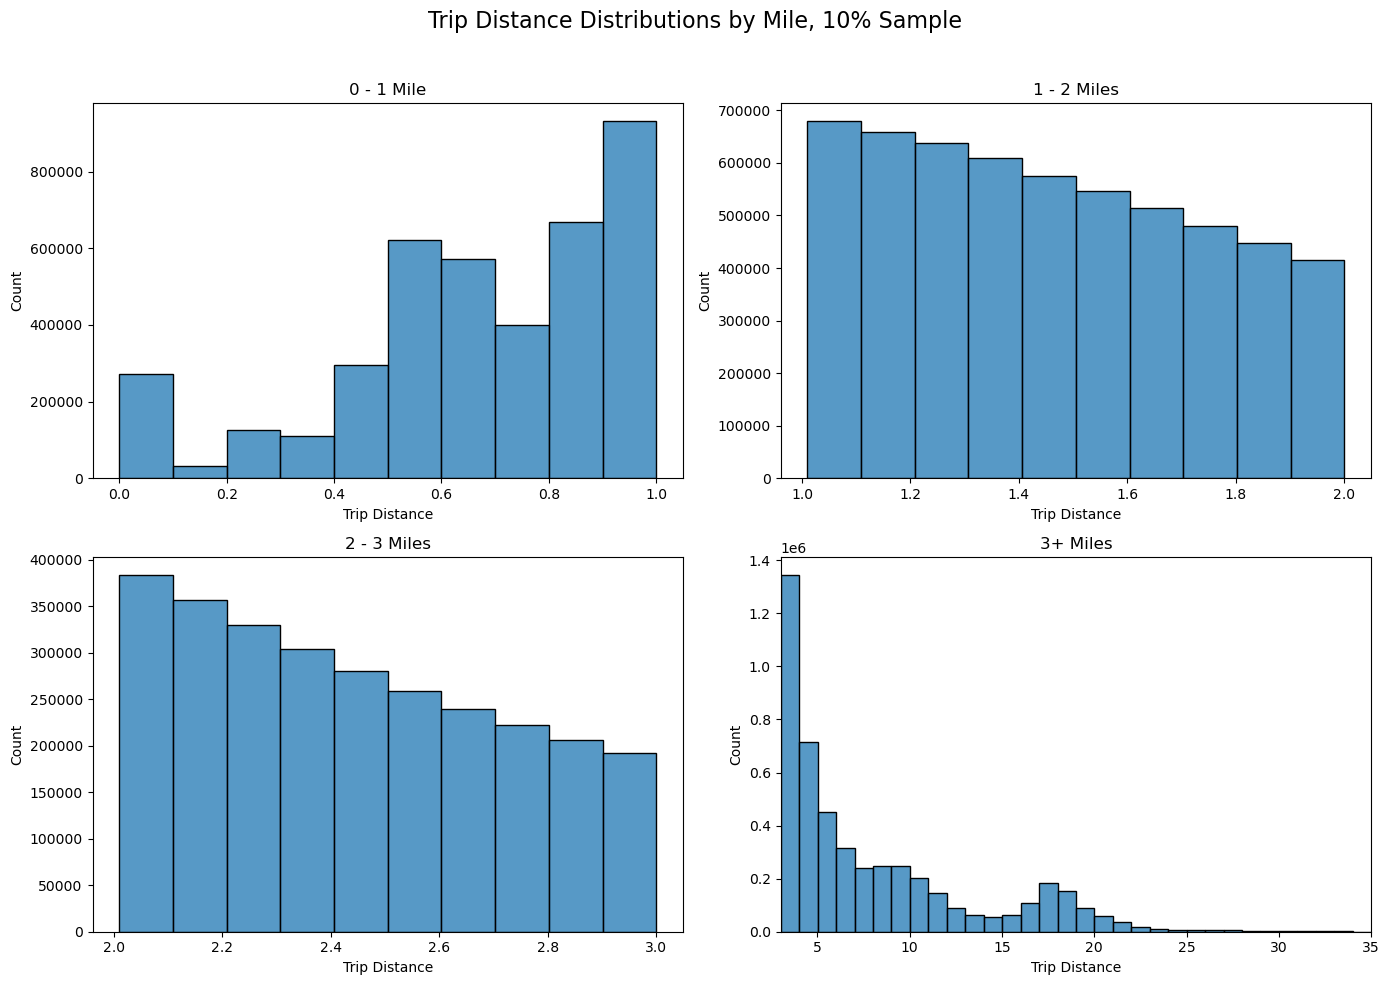

In [14]:
# Histogram of Trip Distance by Mile

# Filter sampled data for trip distance ranges
mile_0_1 = df.filter((col("trip_distance") >= 0) & (col("trip_distance") <= 1)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_1_2 = df.filter((col("trip_distance") > 1) & (col("trip_distance") <= 2)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_2_3 = df.filter((col("trip_distance") > 2) & (col("trip_distance") <= 3)) \
             .select("trip_distance").sample(fraction=0.1).toPandas()
mile_3_plus = df.filter((col("trip_distance") > 3) & (col("trip_distance") <= 35)) \
                .select("trip_distance").sample(fraction=0.1).toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Trip Distance Distributions by Mile, 10% Sample", fontsize=16)

# 0–1 mile
sns.histplot(mile_0_1["trip_distance"], bins=10, ax=axes[0, 0])
axes[0, 0].set_title("0 - 1 Mile")
axes[0, 0].set_xlabel("Trip Distance")
axes[0, 0].set_ylabel("Count")

# 1–2 miles
sns.histplot(mile_1_2["trip_distance"], bins=10, ax=axes[0, 1])
axes[0, 1].set_title("1 - 2 Miles")
axes[0, 1].set_xlabel("Trip Distance")
axes[0, 1].set_ylabel("Count")

# 2–3 miles
sns.histplot(mile_2_3["trip_distance"], bins=10, ax=axes[1, 0])
axes[1, 0].set_title("2 - 3 Miles")
axes[1, 0].set_xlabel("Trip Distance")
axes[1, 0].set_ylabel("Count")

# 3+ miles
sns.histplot(mile_3_plus["trip_distance"], bins=32, ax=axes[1, 1])
axes[1, 1].set_title("3+ Miles")
axes[1, 1].set_xlabel("Trip Distance")
axes[1, 1].set_ylabel("Count")
axes[1, 1].set_xlim(3, 35)

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

#### Most trips are short distances. The standard rate (ratecode = 1) is for NYC county only. Filtering for trips >= 0 and <= 35 miles as the distance of NYC is approx 35 miles. "...the longest distance between its boundaries, from the northeast to the southwest, is about 35 miles."

##### source: https://www.takewalks.com/blog/nyc-by-the-numbers#:~:text=The%20total%20area%20of%20the,Staten%20Island%20and%20Long%20Island.

In [11]:
# Filter Trip Distance
df = df.filter((col("trip_distance") >= 0) & (col("trip_distance") <= 35))

### RatecodeID

In [12]:
ratecode_counts = df.groupBy("RatecodeID").count()

metered_row = ratecode_counts.filter(col("RatecodeID") == 1).collect()[0]
metered_count = metered_row["count"]

total_count = ratecode_counts.agg({"count": "sum"}).collect()[0][0]

print(f"Metered fare rides (RatecodeID == 1): {metered_count:,}")
print(f"Percentage of rides (RatecodeID == 1): {metered_count / total_count:.2%}")

Metered fare rides (RatecodeID == 1): 155,656,072
Percentage of rides (RatecodeID == 1): 90.31%


#### Looking at ratecode = 1, this is metered/standard rate rides. 90% of the rides are metered. Rates codes such as 2 and 3 are flat rates & negociated fares.

##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

##### Below are the rate codes and their meaning. 
###### 1= Standard rate
###### 2=JFK (flat rate)
###### 3=Newark (typically flat rate)
###### 4=Nassau or Westchester (flat rate or negotiated)
###### 5=Negotiated fare
###### 6=Group ride

In [13]:
# Filtering to RatecodeID == 1
df = df.filter(col("RatecodeID") == 1)

### Features

In [18]:
# Correlation with fare amount

columns = ["trip_distance",
           "trip_time_minutes",
           "fare_per_min",
           "fare_per_mile",
           "passenger_count",
           "hour",
           "dayofweek",
           "month",
           "payment_type",
           "congestion_surcharge",
           "tolls_amount",
           "tip_amount",
           "fare_amount"] # Target column for sampling
    
# Sampling 10%
corr_df = df.select(columns).sample(fraction=0.1, seed=2).toPandas()

fare_corr = corr_df.corr(numeric_only=True)["fare_amount"].sort_values(ascending=False)
print("Correlation with fare_amount, 10% Sample:")
print(fare_corr)

Correlation with fare_amount, 10% Sample:
fare_amount             1.000000
trip_distance           0.911872
tip_amount              0.552115
tolls_amount            0.465093
month                   0.049875
hour                    0.009840
fare_per_min            0.007386
passenger_count         0.002200
trip_time_minutes       0.002023
dayofweek              -0.011996
payment_type           -0.019208
fare_per_mile          -0.098803
congestion_surcharge   -0.287660
Name: fare_amount, dtype: float64


#### trip_distance, tip_amount and tolls_amount all have strong to moderate correlations to fare_amount. 
#### Tip amount will not be used because tips are not known until the ride is over. Tip amount is discretionary, we are predicting the price of fare  for a customer's ride, not the fare plus tip. 
#### Adding trip_in_minutes reduces rmse by more than half. This is likely because riders are also charged per minute. 
#### "70 cents for every 1/5 of a mile when traveling above 12 miles per hour or per 60 seconds in slow traffic or when the vehicle is stopped"
##### source: https://portal.311.nyc.gov/article/?kanumber=KA-01245

In [15]:
zero_trip_time_count = df.filter(col("trip_time_minutes") == 0).count()
print(f"Rows with zero trip_time_minutes: {zero_trip_time_count}")

Rows with zero trip_time_minutes: 44077


In [16]:
# Filter extreme outliers for trip_time_minutes and tolls_amount

df = df.filter((col("trip_time_minutes") > 0) & (col("trip_time_minutes") <= 1500) &
               (col("tolls_amount") >= 0) & (col("tolls_amount") <= 100))

In [17]:
# Data remaining after processing
original_count = 174689444 # raw_df.count()
filtered_count = df.count()
percent_remaining = (filtered_count / original_count) * 100

print(f"Original row count: {original_count}")
print(f"Filtered row count: {filtered_count}")
print(f"\nPercentage of data retained: {percent_remaining:.2f}%")


Original row count: 174689444
Filtered row count: 155608365

Percentage of data retained: 89.08%


#### We retained 89%% of the overall data after preprocessing.

# **Train Model**

In [18]:
features = ["trip_distance", "trip_time_minutes", "tolls_amount"]
target = "fare_amount"

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_ml = assembler.transform(df).select("features", target)

train_data, test_data = df_ml.randomSplit([0.8, 0.2], seed=2)

In [19]:
print('Test Size:',train_data.count())
print('Test Size:',test_data.count())

Test Size: 124476955
Test Size: 31131410


### Linear Regression (Baseline Model)

In [20]:
# Baseline Linear Regression Model

lr = LinearRegression(featuresCol="features", labelCol="fare_amount")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", 
                                     predictionCol="prediction", 
                                     metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="fare_amount", 
                                    predictionCol="prediction", 
                                    metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="fare_amount", 
                                   predictionCol="prediction", 
                                   metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Linear Reg RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Linear Reg RMSE: 4.33
MAE: 2.95
R² Score: 0.8342


### GBT Regressor

In [ ]:
# Spark's Gradient Boost Tree Regressor

gbt = GBTRegressor(featuresCol="features", 
                   labelCol="fare_amount", 
                   maxIter=50, 
                   maxDepth=5, 
                   stepSize=0.1, 
                   seed=2)
gbt_model = gbt.fit(train_data)
gbt_pred = gbt_model.transform(test_data)

print("\nGBT Regression:")
print(f"RMSE: {evaluator_rmse.evaluate(gbt_pred):.2f}")
print(f"MAE:  {evaluator_mae.evaluate(gbt_pred):.2f}")
print(f"R²:   {evaluator_r2.evaluate(gbt_pred):.4f}")

### LightGBM Regressor

#### While testing locally and on subsets of the data, LightGBM consistantly had the most accuracy so this is the model we chose to move forward with. 

In [22]:
# LightGB Model

# 10%, NEED TO FIGURE OUT MEMORY
train_pd = train_data.select("features", "fare_amount").sample(fraction=.1, seed=2).toPandas()
test_pd  = test_data.select("features", "fare_amount").sample(fraction=.1, seed=2).toPandas()

# Extract features from Vector column
X_train = np.vstack(train_pd["features"])
y_train = train_pd["fare_amount"]

X_test = np.vstack(test_pd["features"])
y_test = test_pd["fare_amount"]


lgb_model = LGBMRegressor(n_estimators=50,
                          max_depth=8,
                          learning_rate=0.1,
                          n_jobs=-1,
                          random_state=2,
                          verbose=-1)
lgb_model.fit(X_train, y_train)

# Train Error
y_train_pred = lgb_model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Test Error
y_pred_lgb = lgb_model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("Done Training")

Done Training


# **Evaluate Model**

### Train/test performance

In [23]:
print("LightGBM Training Performance:")
print(f"  RMSE: {rmse_train:.2f}")
print(f"  LightGBM MAE: {mae_train:.2f}")
print(f"  R² Score: {r2_train:.4f}")

print("\nLightGBM Test Performance:")
print(f"  RMSE: {rmse_lgb:.2f}")
print(f"  MAE: {mae_lgb:.2f}")
print(f"  R² Score: {r2_lgb:.4f}")

LightGBM Training Performance:
  RMSE: 2.73
  LightGBM MAE: 1.95
  R² Score: 0.9340

LightGBM Test Performance:
  RMSE: 2.74
  MAE: 1.95
  R² Score: 0.9337


#### Model performs nearly the same on 10% sample as it did locally ran subsets of data. 

### Examples

In [29]:
# Train examples
train_preds = lgb_model.predict(X_train)
train_examples = pd.DataFrame(X_train, columns=["trip_distance", "trip_time_minutes", "tolls_amount"])
train_examples["actual"] = y_train
train_examples["predicted"] = train_preds
train_examples["split"] = "Train"

# Test examples
test_preds = lgb_model.predict(X_test)
test_examples = pd.DataFrame(X_test, columns=["trip_distance", "trip_time_minutes", "tolls_amount"])
test_examples["actual"] = y_test
test_examples["predicted"] = test_preds
test_examples["split"] = "Test"

examples = pd.concat([train_examples, test_examples]).round(2)
examples.sample(5)


,trip_distance,trip_time_minutes,tolls_amount,actual,predicted,split
1787462,4.31,8.10,0.0,18.4,13.97,Test
2441182,1.90,12.67,0.0,10.0,11.35,Train
2971600,0.87,13.65,0.0,12.8,11.44,Test
2616889,0.67,7.32,0.0,7.9,7.24,Test
2102805,1.50,8.95,0.0,8.0,8.99,Train


# **Model Fit**

### LightGBM Model Residuals

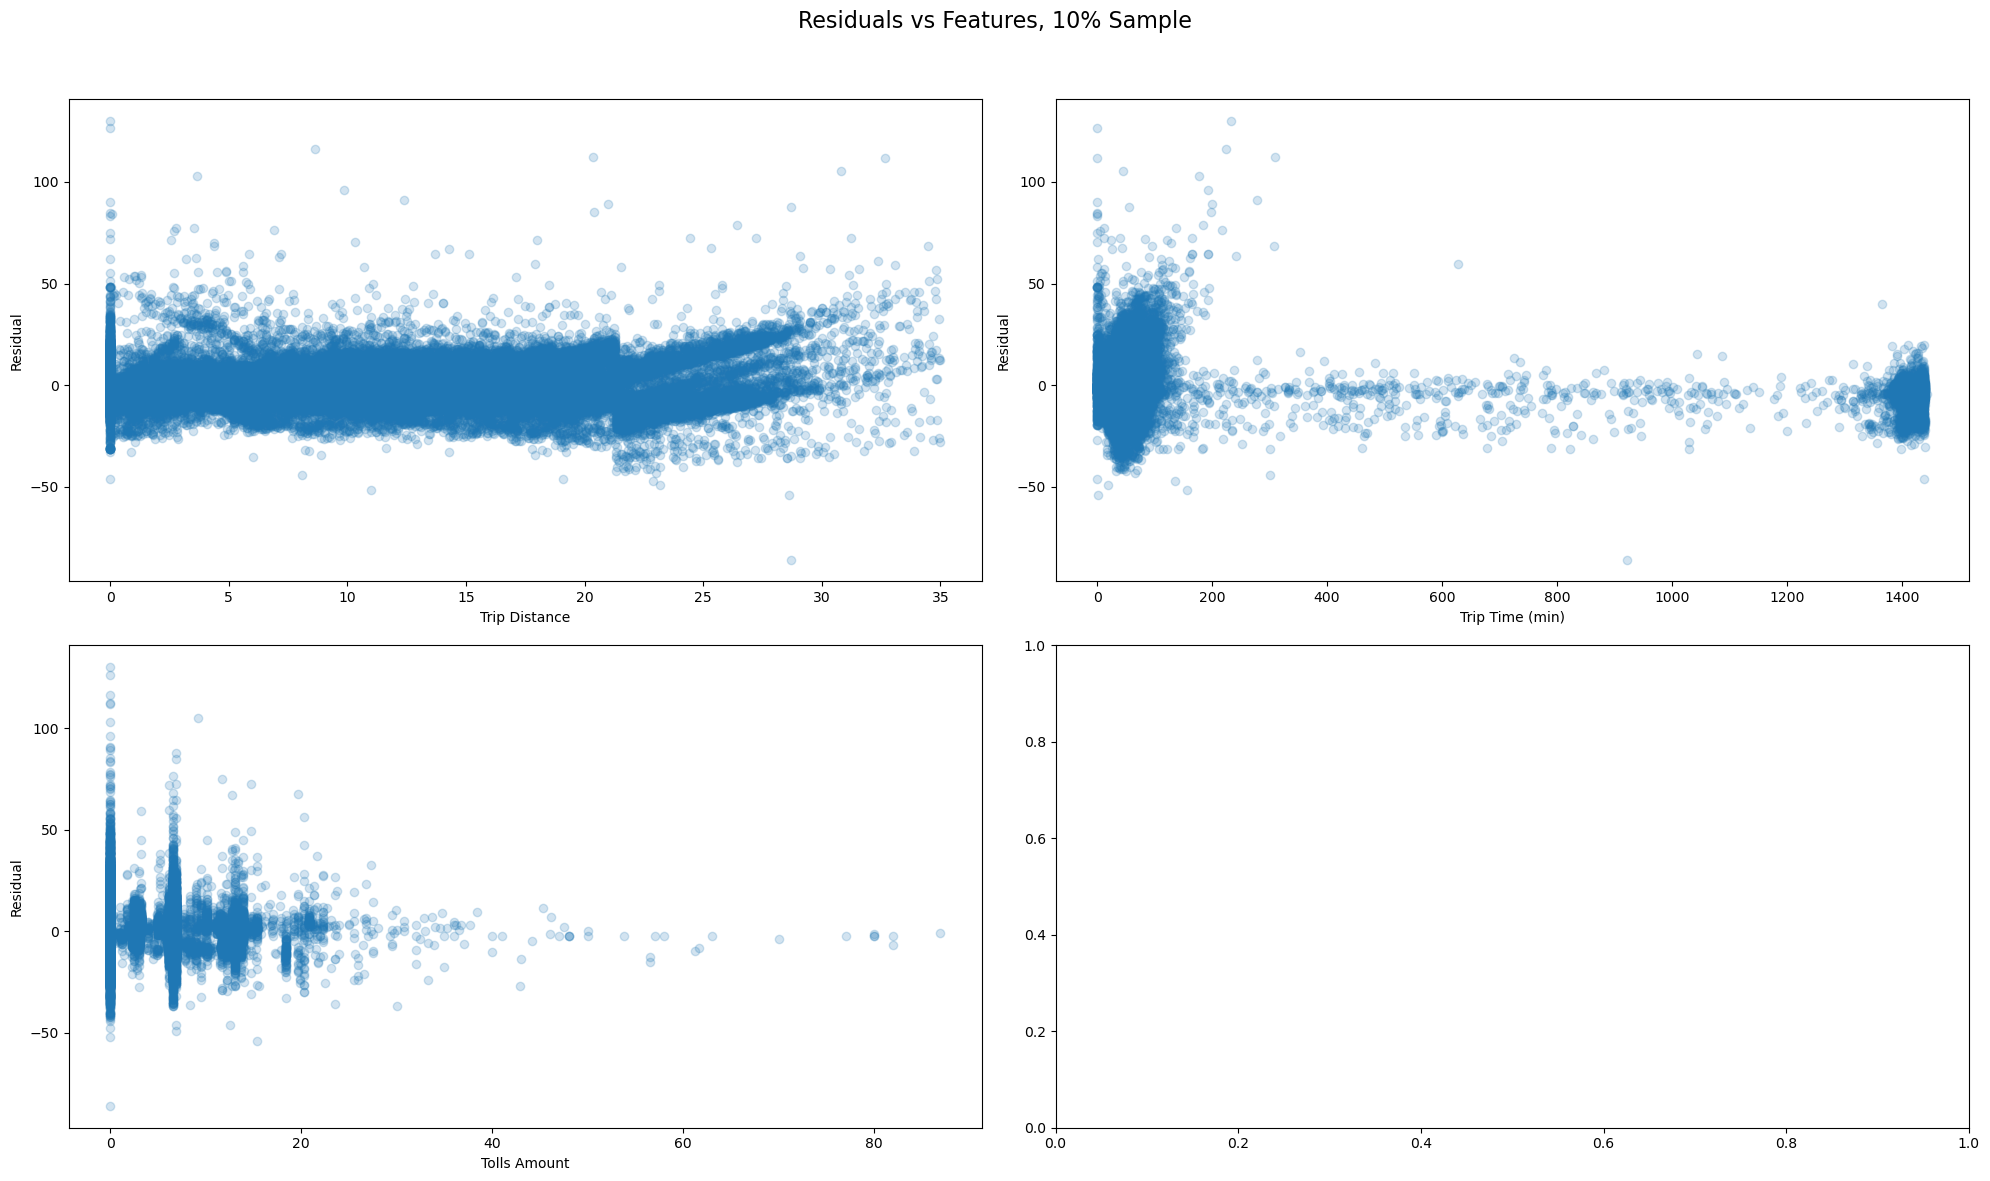

In [24]:
feature_names = ["trip_distance", "trip_time_minutes", "tolls_amount"]

# Convert feature vectors to a 2D array
X_test_array = np.vstack(test_pd["features"])
X_test_df = pd.DataFrame(X_test_array, columns=feature_names)

# Calculate residuals
resid = y_test - y_pred_lgb

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("Residuals vs Features, 10% Sample", fontsize=16)

axes[0,0].scatter(X_test_df["trip_distance"], resid, alpha=0.2)
axes[0,0].set_xlabel("Trip Distance")
axes[0,0].set_ylabel("Residual")

axes[0,1].scatter(X_test_df["trip_time_minutes"], resid, alpha=0.2)
axes[0,1].set_xlabel("Trip Time (min)")
axes[0,1].set_ylabel("Residual")

axes[1,0].scatter(X_test_df["tolls_amount"], resid, alpha=0.2)
axes[1,0].set_xlabel("Tolls Amount")
axes[1,0].set_ylabel("Residual")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Conclusion

#### Summary of Results
We successfully built and evaluated a predictive model for NYC taxi fare estimation, starting with Linear Regression and moving to a more advanced LightGBM regressor. After preprocessing over 174 million rows, we retained 89% of the dataset, ensuring statistical richness while filtering for consistency (e.g., RateCodeID = 1).

The Linear Regression baseline produced an R² score of 0.83, indicating decent linear relationships between features (especially trip distance) and fare. 

By switching to **LightGBM**, performance improved significantly:

**Test RMSE: 2.74**

**Test MAE: 1.95**

**R² Score: 0.9337**

These gains show that the model captures both proportional fare dynamics and nonlinearities like tolls, time-based charges, and structured pricing behaviors.

#### Error Analysis
Residual plots show generally balanced errors across distance and time, but:

-Some underprediction exists on longer trips.

-Small clusters of large residuals appear at unusual trip times or distances, possibly due to unmodeled surcharges or flat fare edge cases.

-Prediction errors for individual samples are within reasonable bounds, further confirming model reliability.

#### Opportunities for Improvement
Time-Aware Modeling: Fare structures can shift year to year due to regulatory changes, inflation adjustments, and policy updates. Using fewer recent years or the previous year might better capture current pricing dynamics and improve predictive relevance for upcoming fare estimates.

Model Tuning: Grid search or Bayesian optimization for LightGBM hyperparameters could yield additional performance gains.

External Features: Incorporate live or historical traffic, weather, or event data to better explain trip time anomalies.

#### Final Thoughts
The LightGBM model provides a strong foundation for fare prediction with high generalization on unseen data. It captures the pricing structure of NYC taxi rides effectively and highlights the value of enriched, cleaned, and expanded features in regression tasks. Going forward, improvements should focus on edge case handling, richer time-based context, and deep tuning for maximum precision.